In [90]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score


import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm



In [135]:
data = pd.read_csv("data/kc_house_data.csv")
data.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

/Users/eeekon/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/eeekon/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/eeekon/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/eeekon/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

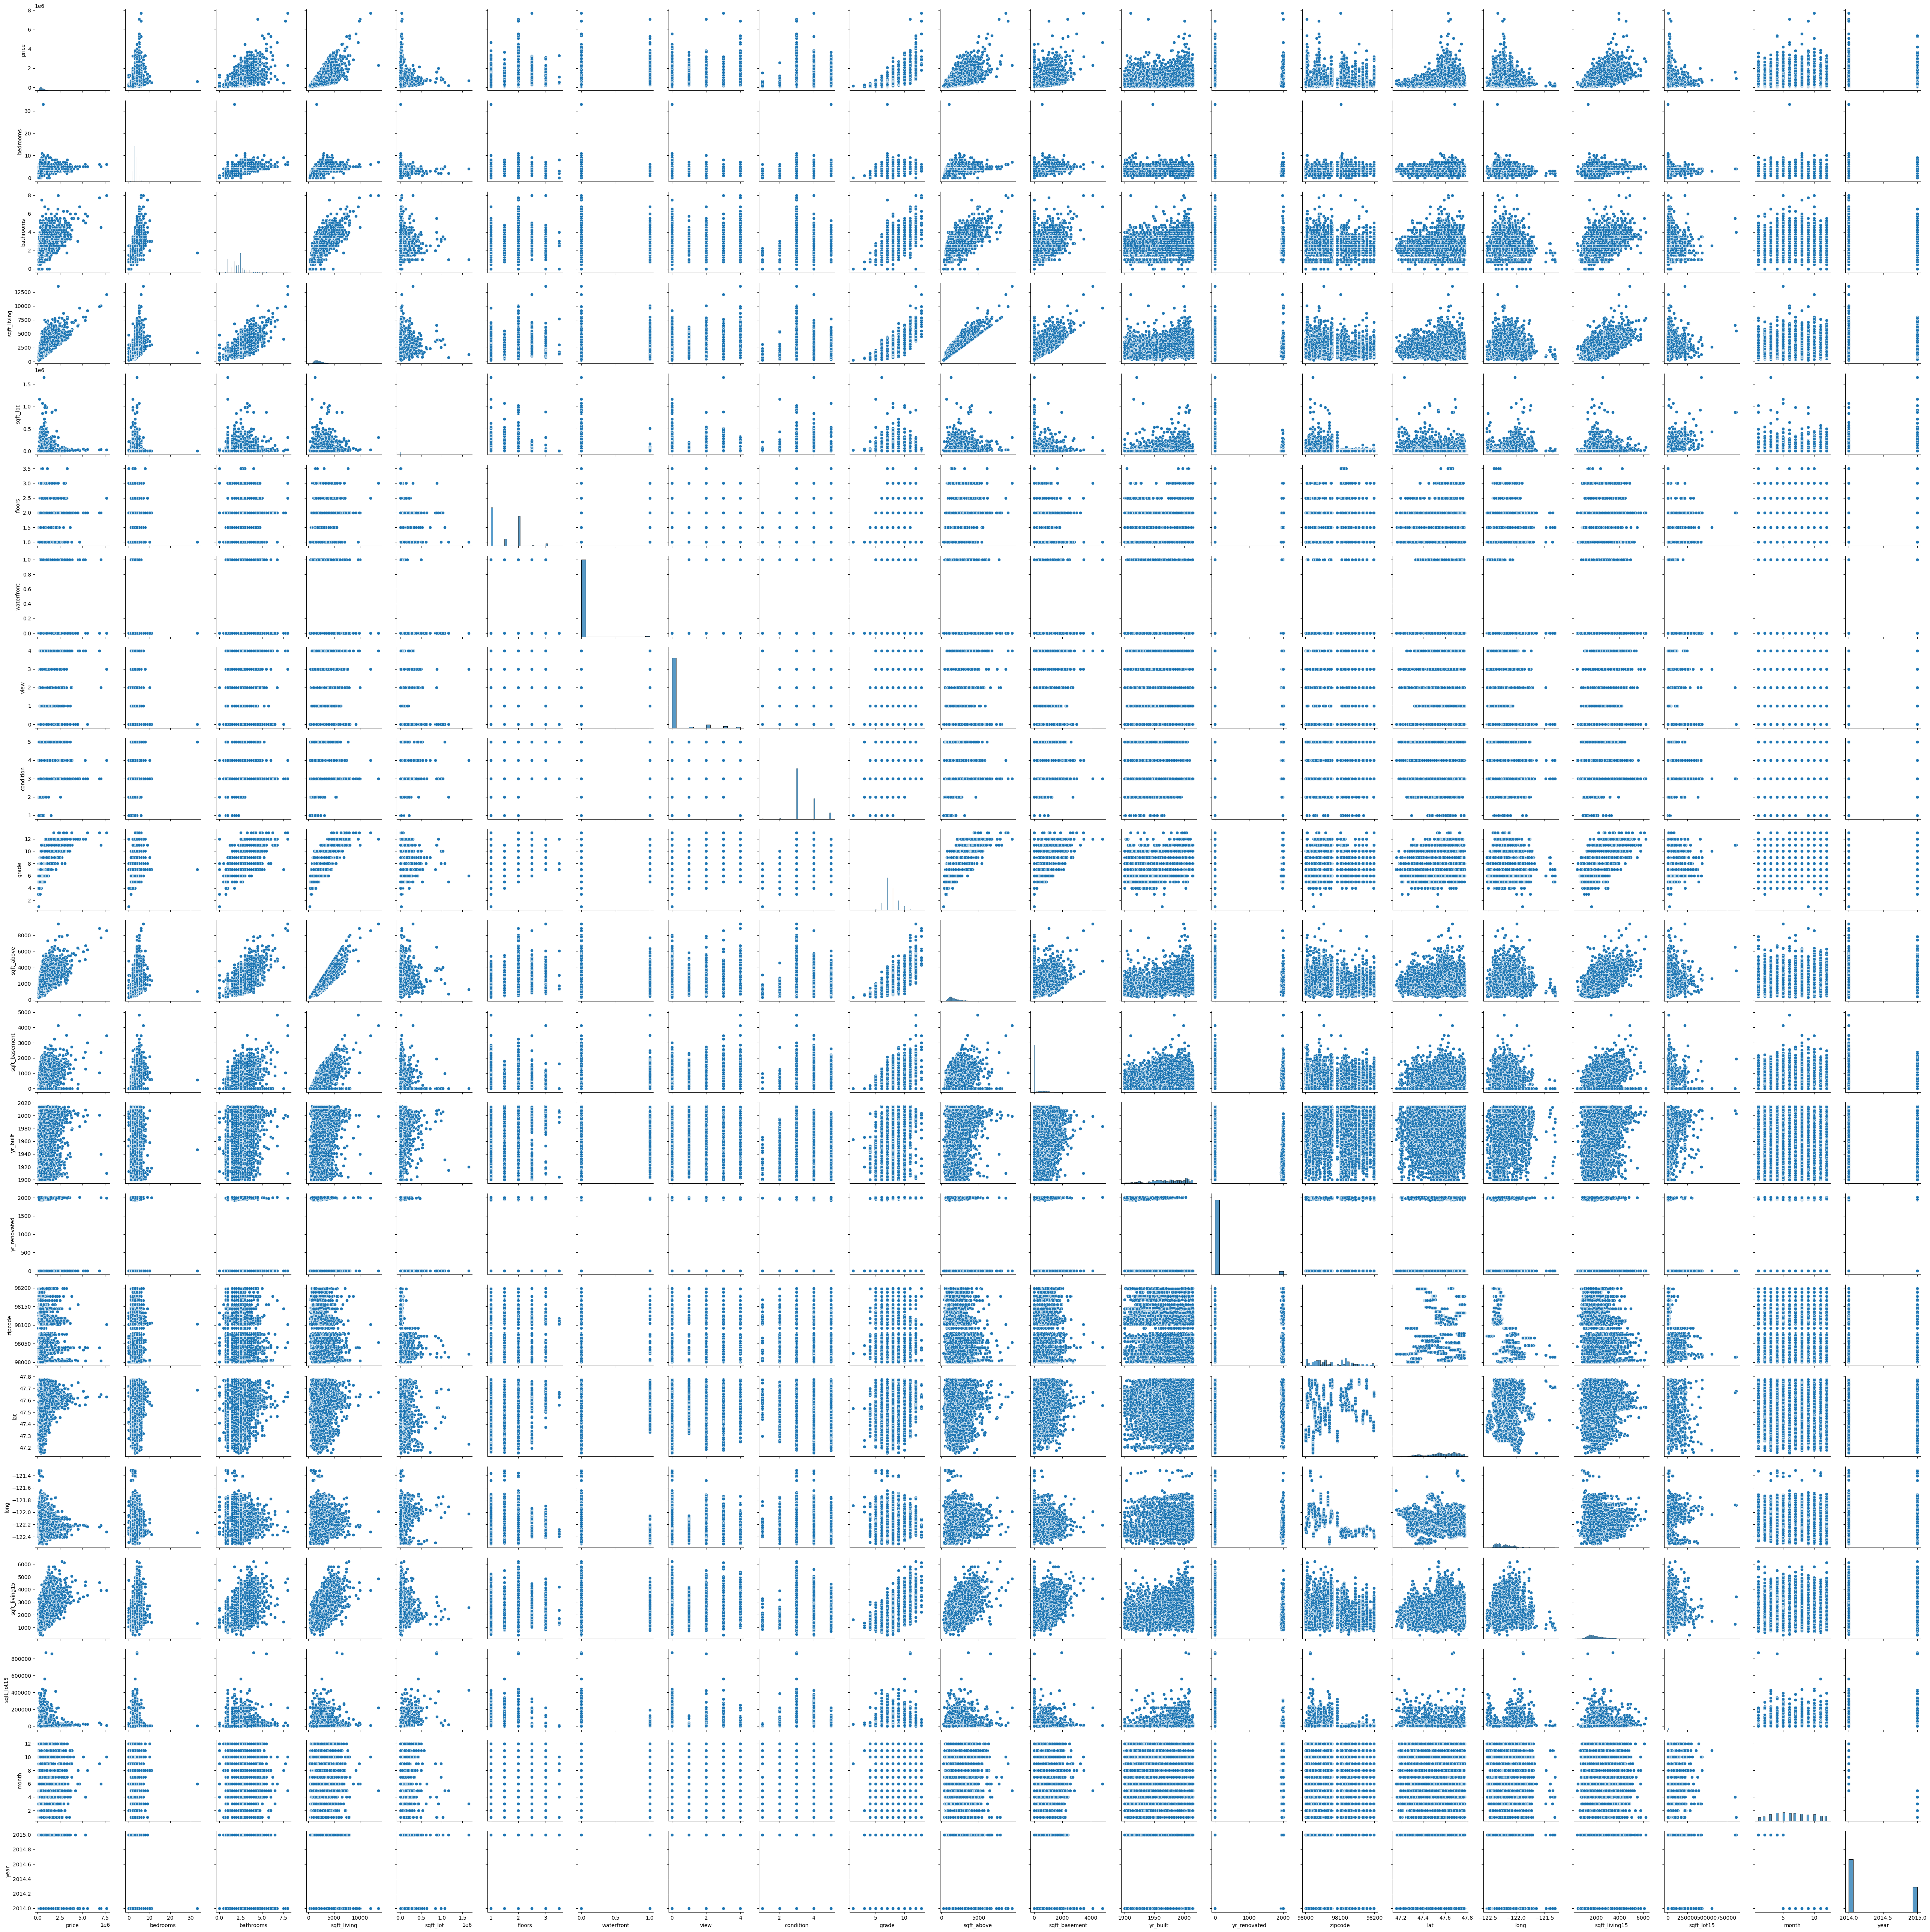

In [88]:
sns.pairplot(data)

In [95]:
data.hvplot.hist(by="price", subplots = True)

:NdLayout   [Default]
   :Histogram   [year]   (year_count)

/Users/eeekon/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price', ylabel='Count'>

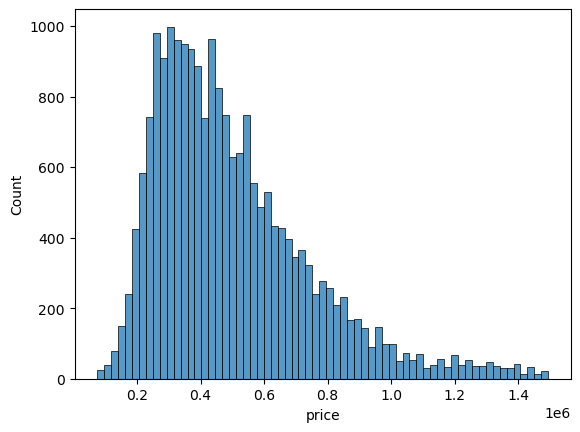

In [114]:
sns.histplot(data[data.price < 1500000].price)

<Axes: xlabel='zipcode', ylabel='price'>

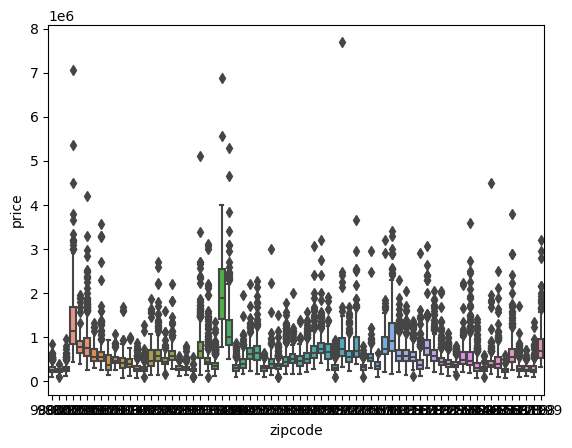

In [117]:
sns.boxplot(y = data.price, x = data.zipcode)

<Axes: ylabel='price'>

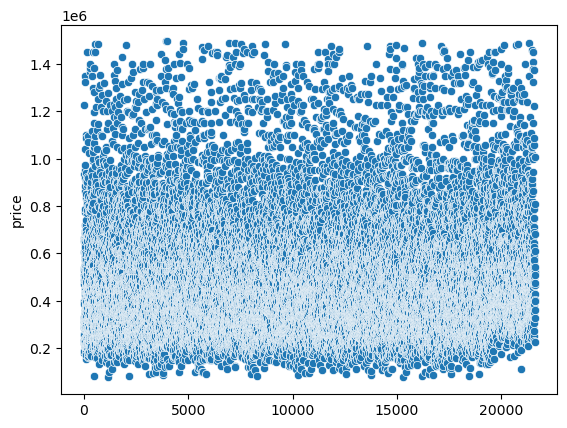

In [121]:
sns.scatterplot(data[data.price < 1500000].price)

In [136]:
data = data.drop("id", axis=1)
data["month"] = data["date"].apply(lambda x : pd.to_datetime(x).month)
data["year"] = data["date"].apply(lambda x : pd.to_datetime(x).year)
data.drop(columns="date", inplace=True)

In [137]:
def dummification (df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix, dtype=int)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [138]:
data = dummification(data, "zipcode", "zip")


In [139]:
data.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  ...  zip_98146  zip_98148  zip_98155  zip_98166  \
0     0          3      7  ...          0          0          0          0   
1     0          3      7  ...          0          0          0          0   
2     0          3      6  ...          0          0          0          0   
3     0          5      7  ...          0          0          0          0   
4     0          3      8  ...          0          0          0          0   

   zip_98168  zip_98177  zip_98178  zip_98188  zip_98198  zip_98199  
0          0          0          1          0          0          0  
1          0          0          0          0          0          0  
2          0          0          0          0          0          0  
3          0          0          0          0          0          0  
4          0          0          0          0          0          0  

[5 rows x 90 columns]

In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 90 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  lat            21613 non-null  float64
 15  long           21613 non-null  float64
 16  sqft_living15  21613 non-null  int64  
 17  sqft_lot15     21613 non-null  int64  
 18  month 

In [140]:
data.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  2.161300e+04   
mean   5.400881e+05      3.370842      2.114757   2079.899736  1.510697e+04   
std    3.671272e+05      0.930062      0.770163    918.440897  4.142051e+04   
min    7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.219500e+05      3.000000      1.750000   1427.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068800e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean       1.494309      0.007542      0.234303      3.409430      7.656873   
std        0.539989      0.086517      0.766318      0.650743      1.175459   
min        1.000000      0.000000      0.000000      1.000000      1.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

       ...     zip_98146     zip_98148     zip_98155     zip_98166  \
count  ...  21613.000000  21613.000000  21613.000000  21613.000000   
mean   ...      0.013325      0.002637      0.020636      0.011752   
std    ...      0.114666      0.051288      0.142165      0.107771   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

          zip_98168     zip_98177     zip_98178     zip_98188     zip_98198  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean       0.012446      0.011798      0.012122      0.006293      0.012955   
std        0.110869      0.107981      0.109435      0.079077      0.113084   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          zip_98199  
count  21613.000000  
mean       0.014667  
std        0.120219  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 90 columns]

In [141]:
data.yr_renovated.value_counts()

yr_renovated
0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: count, Length: 70, dtype: int64

In [142]:
data.drop(columns=["yr_renovated"], inplace=True)

In [143]:
data = data[data.price < 1500000]

Scale & Split

In [144]:
X = data.copy()
y = X.pop("price")

In [145]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14755, 88), (6325, 88), (14755,), (6325,))

Le modele


In [147]:
class Net(nn.Module) : 
    def __init__(self) :
        super(Net, self).__init__()
        self.layer1 = nn.Linear(88, 64)
        self.layer2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 1)


    def forward(self, x) : 
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.out(x)
        return x

net = Net()

In [148]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [149]:
net.parameters

<bound method Module.parameters of Net(
  (layer1): Linear(in_features=88, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)>

In [150]:
list(net.parameters())

[Parameter containing:
 tensor([[ 0.0420,  0.0958, -0.0686,  ...,  0.0154,  0.0535, -0.0031],
         [-0.0977,  0.0768,  0.0855,  ...,  0.0515, -0.0530, -0.0510],
         [-0.0018,  0.0336, -0.0525,  ...,  0.0634, -0.0910,  0.0447],
         ...,
         [ 0.0287,  0.1057,  0.0576,  ...,  0.0878, -0.0819, -0.0438],
         [-0.0664,  0.0344,  0.0667,  ..., -0.0447, -0.0599,  0.0799],
         [-0.0570,  0.0166,  0.0764,  ...,  0.0013,  0.0430, -0.1022]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0501,  0.0813,  0.0153, -0.0041, -0.0889,  0.0721,  0.0932,  0.0676,
         -0.0195,  0.0449, -0.0475, -0.0782, -0.0323, -0.0709,  0.0497,  0.0810,
         -0.0078,  0.0992,  0.0236, -0.1015,  0.1023,  0.0044,  0.0083, -0.0071,
          0.0961, -0.0645, -0.0386,  0.0855, -0.0083, -0.0377, -0.0307,  0.0587,
         -0.0657,  0.0755,  0.0390, -0.0204,  0.1021, -0.0619, -0.1024,  0.0419,
          0.0334, -0.0835, -0.0668, -0.0164, -0.0562,  0.0440, -0.0355,  0.0837

In [151]:
for i in range(len(list(net.parameters()))) :
    print(list(net.parameters())[i].shape)

torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])


Les données en tenseur

In [152]:
torch_X_train = torch.from_numpy(X_train)
torch_X_test = torch.from_numpy(X_test)
torch_y_train = torch.from_numpy(y_train.values)
torch_y_test = torch.from_numpy(y_test.values)

Apprentissage

In [153]:

loss_values = []
i = 0
for x, target in tqdm(zip(torch_X_train, torch_y_train.unsqueeze(1)) ): 
    
    x = x.type(torch.float)
    target = target.type(torch.float)
    
    optimizer.zero_grad()
    output = net(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    i+=1
    if i % 200 == 0 : 
        loss_values.append(loss)


14755it [00:03, 4084.55it/s]


In [154]:
loss_values = [w.item() for w in loss_values]
loss_values

[159780978688.0,
 122708385792.0,
 8940760064.0,
 280173184.0,
 240169762816.0,
 66773352448.0,
 200952807424.0,
 359773700096.0,
 3595152896.0,
 3369769728.0,
 6672418816.0,
 43006193664.0,
 3790480128.0,
 2832315136.0,
 104995248.0,
 666813792256.0,
 4429908992.0,
 637322624.0,
 3575939072.0,
 3137960192.0,
 9783496704.0,
 16807080960.0,
 3167987200.0,
 6469150720.0,
 617016256.0,
 6532150272.0,
 12150893568.0,
 1956475392.0,
 1215654002688.0,
 15476666368.0,
 4004126.0,
 36394790912.0,
 12505459712.0,
 1735420160.0,
 1718045568.0,
 20655042560.0,
 8839825408.0,
 4356091.0,
 25701732.0,
 10259609.0,
 221686976.0,
 210870583296.0,
 668416384.0,
 86984409088.0,
 3259917568.0,
 10336001024.0,
 75135434752.0,
 33097967616.0,
 7804689920.0,
 1923458432.0,
 289903840.0,
 466113248.0,
 3454978304.0,
 5761042432.0,
 12569661440.0,
 2734802944.0,
 6532928000.0,
 304953088.0,
 18178217984.0,
 135207472.0,
 83426615296.0,
 374902784.0,
 12477992960.0,
 920615168.0,
 158822224.0,
 11267517440.0,

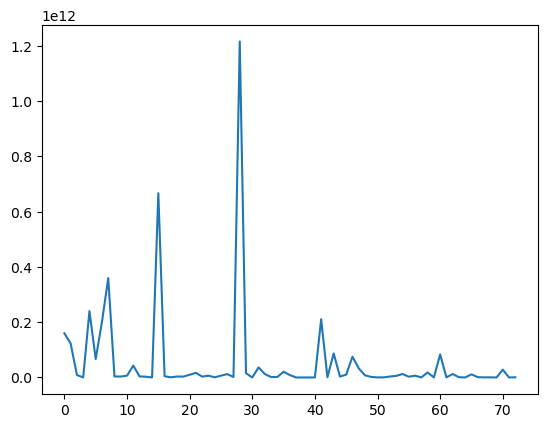

In [155]:
plt.plot(loss_values)
plt.show()

In [156]:
total_loss = 0 
for x, target in tqdm(zip(torch_X_test, torch_y_test.unsqueeze(1))) : 
    x = x.type(torch.float)
    target = target.type(torch.float)
    
    output = net(x)
    loss = criterion(output, target)
    total_loss += loss

avg_loss = total_loss / len(torch_X_test)
avg_loss

6325it [00:00, 28374.57it/s]


tensor(1.9280e+10, grad_fn=<DivBackward0>)

In [157]:
torch_rmse = torch.sqrt(avg_loss).detach().numpy()
torch_rmse


array(138851.27, dtype=float32)

Nouveau modele

In [158]:
train_dataset = TensorDataset(torch_X_train, torch_y_train)
test_dataset = TensorDataset(torch_X_test, torch_y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [159]:
train_dataset = TensorDataset(torch_X_train, torch_y_train)
test_dataset = TensorDataset(torch_X_test, torch_y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [161]:
class HousePriceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(HousePriceModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        return x


In [162]:

# Define model, optimizer, and loss function
model = HousePriceModel(torch_X_train.shape[1], 128, 64, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
criterion = nn.MSELoss()


In [163]:

# Train the model
loss_values_2 = []
epochs = 100
for epoch in tqdm(range(epochs)):
    for i, (features, labels) in enumerate(train_loader):
        features = features.type(torch.float)
        labels = labels.type(torch.float)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            loss_values_2.append(loss.item())
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Step [200/462], Loss: 308761034752.0000


  1%|          | 1/100 [00:00<00:56,  1.77it/s]

Epoch [1/100], Step [400/462], Loss: 247263035392.0000
Epoch [2/100], Step [200/462], Loss: 271101853696.0000


  2%|▏         | 2/100 [00:01<00:56,  1.75it/s]

Epoch [2/100], Step [400/462], Loss: 337430511616.0000
Epoch [3/100], Step [200/462], Loss: 297272999936.0000


  3%|▎         | 3/100 [00:01<00:54,  1.79it/s]

Epoch [3/100], Step [400/462], Loss: 348194177024.0000
Epoch [4/100], Step [200/462], Loss: 237776142336.0000


  4%|▍         | 4/100 [00:02<00:52,  1.83it/s]

Epoch [4/100], Step [400/462], Loss: 277268660224.0000
Epoch [5/100], Step [200/462], Loss: 162539470848.0000


  5%|▌         | 5/100 [00:02<00:52,  1.81it/s]

Epoch [5/100], Step [400/462], Loss: 360290713600.0000
Epoch [6/100], Step [200/462], Loss: 267267178496.0000


  6%|▌         | 6/100 [00:03<00:51,  1.83it/s]

Epoch [6/100], Step [400/462], Loss: 410394886144.0000
Epoch [7/100], Step [200/462], Loss: 268052987904.0000


  7%|▋         | 7/100 [00:03<00:50,  1.83it/s]

Epoch [7/100], Step [400/462], Loss: 250785742848.0000
Epoch [8/100], Step [200/462], Loss: 241997742080.0000


  8%|▊         | 8/100 [00:04<00:49,  1.84it/s]

Epoch [8/100], Step [400/462], Loss: 244009041920.0000
Epoch [9/100], Step [200/462], Loss: 372997095424.0000


  9%|▉         | 9/100 [00:04<00:50,  1.81it/s]

Epoch [9/100], Step [400/462], Loss: 254075781120.0000
Epoch [10/100], Step [200/462], Loss: 257142833152.0000


 10%|█         | 10/100 [00:05<00:49,  1.83it/s]

Epoch [10/100], Step [400/462], Loss: 258994962432.0000
Epoch [11/100], Step [200/462], Loss: 463229714432.0000


 11%|█         | 11/100 [00:06<00:48,  1.84it/s]

Epoch [11/100], Step [400/462], Loss: 290244132864.0000
Epoch [12/100], Step [200/462], Loss: 359958282240.0000


 12%|█▏        | 12/100 [00:06<00:47,  1.85it/s]

Epoch [12/100], Step [400/462], Loss: 319696175104.0000
Epoch [13/100], Step [200/462], Loss: 246544220160.0000


 13%|█▎        | 13/100 [00:07<00:46,  1.86it/s]

Epoch [13/100], Step [400/462], Loss: 505165217792.0000
Epoch [14/100], Step [200/462], Loss: 440619794432.0000


 14%|█▍        | 14/100 [00:07<00:46,  1.86it/s]

Epoch [14/100], Step [400/462], Loss: 370690818048.0000
Epoch [15/100], Step [200/462], Loss: 238491877376.0000


 15%|█▌        | 15/100 [00:08<00:45,  1.86it/s]

Epoch [15/100], Step [400/462], Loss: 211898892288.0000
Epoch [16/100], Step [200/462], Loss: 264873934848.0000


 16%|█▌        | 16/100 [00:08<00:45,  1.86it/s]

Epoch [16/100], Step [400/462], Loss: 333060898816.0000
Epoch [17/100], Step [200/462], Loss: 316992356352.0000


 17%|█▋        | 17/100 [00:09<00:44,  1.87it/s]

Epoch [17/100], Step [400/462], Loss: 326279233536.0000
Epoch [18/100], Step [200/462], Loss: 428388122624.0000


 18%|█▊        | 18/100 [00:09<00:45,  1.82it/s]

Epoch [18/100], Step [400/462], Loss: 185074860032.0000
Epoch [19/100], Step [200/462], Loss: 466457722880.0000


 19%|█▉        | 19/100 [00:10<00:44,  1.84it/s]

Epoch [19/100], Step [400/462], Loss: 267304894464.0000
Epoch [20/100], Step [200/462], Loss: 291612852224.0000


 20%|██        | 20/100 [00:10<00:43,  1.84it/s]

Epoch [20/100], Step [400/462], Loss: 517956927488.0000
Epoch [21/100], Step [200/462], Loss: 345601146880.0000


 21%|██        | 21/100 [00:11<00:42,  1.85it/s]

Epoch [21/100], Step [400/462], Loss: 266580131840.0000
Epoch [22/100], Step [200/462], Loss: 404680802304.0000


 22%|██▏       | 22/100 [00:11<00:42,  1.86it/s]

Epoch [22/100], Step [400/462], Loss: 351880806400.0000
Epoch [23/100], Step [200/462], Loss: 239613902848.0000


 23%|██▎       | 23/100 [00:12<00:41,  1.86it/s]

Epoch [23/100], Step [400/462], Loss: 352950157312.0000
Epoch [24/100], Step [200/462], Loss: 365139263488.0000


 24%|██▍       | 24/100 [00:13<00:40,  1.86it/s]

Epoch [24/100], Step [400/462], Loss: 258303049728.0000
Epoch [25/100], Step [200/462], Loss: 320892174336.0000


 25%|██▌       | 25/100 [00:13<00:40,  1.86it/s]

Epoch [25/100], Step [400/462], Loss: 344337907712.0000
Epoch [26/100], Step [200/462], Loss: 354504048640.0000


 26%|██▌       | 26/100 [00:14<00:40,  1.82it/s]

Epoch [26/100], Step [400/462], Loss: 362513924096.0000
Epoch [27/100], Step [200/462], Loss: 416157073408.0000


 27%|██▋       | 27/100 [00:14<00:39,  1.84it/s]

Epoch [27/100], Step [400/462], Loss: 320942735360.0000
Epoch [28/100], Step [200/462], Loss: 290717696000.0000


 28%|██▊       | 28/100 [00:15<00:39,  1.85it/s]

Epoch [28/100], Step [400/462], Loss: 420318773248.0000
Epoch [29/100], Step [200/462], Loss: 243857588224.0000


 29%|██▉       | 29/100 [00:15<00:38,  1.85it/s]

Epoch [29/100], Step [400/462], Loss: 375213228032.0000
Epoch [30/100], Step [200/462], Loss: 484385652736.0000


 30%|███       | 30/100 [00:16<00:37,  1.85it/s]

Epoch [30/100], Step [400/462], Loss: 382439882752.0000
Epoch [31/100], Step [200/462], Loss: 262845267968.0000


 31%|███       | 31/100 [00:16<00:37,  1.85it/s]

Epoch [31/100], Step [400/462], Loss: 271760424960.0000
Epoch [32/100], Step [200/462], Loss: 190861901824.0000


 32%|███▏      | 32/100 [00:17<00:36,  1.86it/s]

Epoch [32/100], Step [400/462], Loss: 226323857408.0000
Epoch [33/100], Step [200/462], Loss: 378019414016.0000


 33%|███▎      | 33/100 [00:17<00:36,  1.86it/s]

Epoch [33/100], Step [400/462], Loss: 359582892032.0000
Epoch [34/100], Step [200/462], Loss: 285479141376.0000


 34%|███▍      | 34/100 [00:18<00:36,  1.80it/s]

Epoch [34/100], Step [400/462], Loss: 341236908032.0000
Epoch [35/100], Step [200/462], Loss: 209072504832.0000


 35%|███▌      | 35/100 [00:19<00:35,  1.82it/s]

Epoch [35/100], Step [400/462], Loss: 389868224512.0000
Epoch [36/100], Step [200/462], Loss: 402422333440.0000


 36%|███▌      | 36/100 [00:19<00:34,  1.83it/s]

Epoch [36/100], Step [400/462], Loss: 329251618816.0000
Epoch [37/100], Step [200/462], Loss: 215459332096.0000


 37%|███▋      | 37/100 [00:20<00:34,  1.84it/s]

Epoch [37/100], Step [400/462], Loss: 387911614464.0000
Epoch [38/100], Step [200/462], Loss: 279931584512.0000


 38%|███▊      | 38/100 [00:20<00:33,  1.85it/s]

Epoch [38/100], Step [400/462], Loss: 304778805248.0000
Epoch [39/100], Step [200/462], Loss: 328187510784.0000


 39%|███▉      | 39/100 [00:21<00:32,  1.86it/s]

Epoch [39/100], Step [400/462], Loss: 313488113664.0000
Epoch [40/100], Step [200/462], Loss: 221831168000.0000


 40%|████      | 40/100 [00:21<00:32,  1.86it/s]

Epoch [40/100], Step [400/462], Loss: 358211354624.0000
Epoch [41/100], Step [200/462], Loss: 251105017856.0000


 41%|████      | 41/100 [00:22<00:31,  1.86it/s]

Epoch [41/100], Step [400/462], Loss: 326660915200.0000
Epoch [42/100], Step [200/462], Loss: 301512818688.0000


 42%|████▏     | 42/100 [00:22<00:31,  1.82it/s]

Epoch [42/100], Step [400/462], Loss: 253970071552.0000
Epoch [43/100], Step [200/462], Loss: 317347168256.0000


 43%|████▎     | 43/100 [00:23<00:31,  1.83it/s]

Epoch [43/100], Step [400/462], Loss: 247137304576.0000
Epoch [44/100], Step [200/462], Loss: 365745602560.0000


 44%|████▍     | 44/100 [00:23<00:30,  1.84it/s]

Epoch [44/100], Step [400/462], Loss: 270959280128.0000
Epoch [45/100], Step [200/462], Loss: 215338876928.0000


 45%|████▌     | 45/100 [00:24<00:29,  1.86it/s]

Epoch [45/100], Step [400/462], Loss: 327122878464.0000
Epoch [46/100], Step [200/462], Loss: 348776726528.0000


 46%|████▌     | 46/100 [00:24<00:29,  1.86it/s]

Epoch [46/100], Step [400/462], Loss: 331592237056.0000
Epoch [47/100], Step [200/462], Loss: 377211715584.0000


 47%|████▋     | 47/100 [00:25<00:28,  1.86it/s]

Epoch [47/100], Step [400/462], Loss: 238922596352.0000
Epoch [48/100], Step [200/462], Loss: 317556195328.0000


 48%|████▊     | 48/100 [00:26<00:28,  1.86it/s]

Epoch [48/100], Step [400/462], Loss: 280750260224.0000
Epoch [49/100], Step [200/462], Loss: 426301456384.0000


 49%|████▉     | 49/100 [00:26<00:27,  1.86it/s]

Epoch [49/100], Step [400/462], Loss: 228563189760.0000
Epoch [50/100], Step [200/462], Loss: 318337318912.0000


 50%|█████     | 50/100 [00:27<00:27,  1.81it/s]

Epoch [50/100], Step [400/462], Loss: 238278770688.0000
Epoch [51/100], Step [200/462], Loss: 327995228160.0000


 51%|█████     | 51/100 [00:27<00:26,  1.83it/s]

Epoch [51/100], Step [400/462], Loss: 347934621696.0000
Epoch [52/100], Step [200/462], Loss: 356276011008.0000


 52%|█████▏    | 52/100 [00:28<00:26,  1.84it/s]

Epoch [52/100], Step [400/462], Loss: 271010234368.0000
Epoch [53/100], Step [200/462], Loss: 302188658688.0000


 53%|█████▎    | 53/100 [00:28<00:25,  1.84it/s]

Epoch [53/100], Step [400/462], Loss: 274765627392.0000
Epoch [54/100], Step [200/462], Loss: 353735999488.0000


 54%|█████▍    | 54/100 [00:29<00:24,  1.85it/s]

Epoch [54/100], Step [400/462], Loss: 392423145472.0000
Epoch [55/100], Step [200/462], Loss: 350678810624.0000


 55%|█████▌    | 55/100 [00:29<00:24,  1.85it/s]

Epoch [55/100], Step [400/462], Loss: 253320790016.0000
Epoch [56/100], Step [200/462], Loss: 226316533760.0000


 56%|█████▌    | 56/100 [00:30<00:23,  1.86it/s]

Epoch [56/100], Step [400/462], Loss: 353396031488.0000
Epoch [57/100], Step [200/462], Loss: 288235159552.0000


 57%|█████▋    | 57/100 [00:30<00:23,  1.87it/s]

Epoch [57/100], Step [400/462], Loss: 458327031808.0000
Epoch [58/100], Step [200/462], Loss: 404552187904.0000


 58%|█████▊    | 58/100 [00:31<00:23,  1.82it/s]

Epoch [58/100], Step [400/462], Loss: 244349976576.0000
Epoch [59/100], Step [200/462], Loss: 373068267520.0000


 59%|█████▉    | 59/100 [00:32<00:22,  1.84it/s]

Epoch [59/100], Step [400/462], Loss: 304200122368.0000
Epoch [60/100], Step [200/462], Loss: 258216034304.0000


 60%|██████    | 60/100 [00:32<00:21,  1.85it/s]

Epoch [60/100], Step [400/462], Loss: 416646561792.0000
Epoch [61/100], Step [200/462], Loss: 352371277824.0000


 61%|██████    | 61/100 [00:33<00:21,  1.83it/s]

Epoch [61/100], Step [400/462], Loss: 363745673216.0000
Epoch [62/100], Step [200/462], Loss: 265166159872.0000


 62%|██████▏   | 62/100 [00:33<00:20,  1.83it/s]

Epoch [62/100], Step [400/462], Loss: 262773506048.0000
Epoch [63/100], Step [200/462], Loss: 332122062848.0000


 63%|██████▎   | 63/100 [00:34<00:20,  1.84it/s]

Epoch [63/100], Step [400/462], Loss: 251791163392.0000
Epoch [64/100], Step [200/462], Loss: 350879285248.0000


 64%|██████▍   | 64/100 [00:34<00:19,  1.85it/s]

Epoch [64/100], Step [400/462], Loss: 375176331264.0000
Epoch [65/100], Step [200/462], Loss: 331256430592.0000


 65%|██████▌   | 65/100 [00:35<00:18,  1.86it/s]

Epoch [65/100], Step [400/462], Loss: 318996873216.0000
Epoch [66/100], Step [200/462], Loss: 314162348032.0000


 66%|██████▌   | 66/100 [00:35<00:18,  1.83it/s]

Epoch [66/100], Step [400/462], Loss: 299109875712.0000
Epoch [67/100], Step [200/462], Loss: 338830393344.0000


 67%|██████▋   | 67/100 [00:36<00:17,  1.84it/s]

Epoch [67/100], Step [400/462], Loss: 300304891904.0000
Epoch [68/100], Step [200/462], Loss: 305704632320.0000


 68%|██████▊   | 68/100 [00:36<00:17,  1.85it/s]

Epoch [68/100], Step [400/462], Loss: 351701303296.0000
Epoch [69/100], Step [200/462], Loss: 275150536704.0000


 69%|██████▉   | 69/100 [00:37<00:16,  1.85it/s]

Epoch [69/100], Step [400/462], Loss: 237844692992.0000
Epoch [70/100], Step [200/462], Loss: 290657796096.0000


 70%|███████   | 70/100 [00:37<00:16,  1.86it/s]

Epoch [70/100], Step [400/462], Loss: 285733421056.0000
Epoch [71/100], Step [200/462], Loss: 204560285696.0000


 71%|███████   | 71/100 [00:38<00:15,  1.86it/s]

Epoch [71/100], Step [400/462], Loss: 273893621760.0000
Epoch [72/100], Step [200/462], Loss: 259966681088.0000


 72%|███████▏  | 72/100 [00:39<00:15,  1.86it/s]

Epoch [72/100], Step [400/462], Loss: 251049263104.0000
Epoch [73/100], Step [200/462], Loss: 236560449536.0000


 73%|███████▎  | 73/100 [00:39<00:14,  1.81it/s]

Epoch [73/100], Step [400/462], Loss: 378012958720.0000
Epoch [74/100], Step [200/462], Loss: 265078292480.0000


 74%|███████▍  | 74/100 [00:40<00:14,  1.83it/s]

Epoch [74/100], Step [400/462], Loss: 260376068096.0000
Epoch [75/100], Step [200/462], Loss: 347315830784.0000


 75%|███████▌  | 75/100 [00:40<00:13,  1.84it/s]

Epoch [75/100], Step [400/462], Loss: 358467174400.0000
Epoch [76/100], Step [200/462], Loss: 398654275584.0000


 76%|███████▌  | 76/100 [00:41<00:12,  1.85it/s]

Epoch [76/100], Step [400/462], Loss: 288446611456.0000
Epoch [77/100], Step [200/462], Loss: 334925692928.0000


 77%|███████▋  | 77/100 [00:41<00:12,  1.87it/s]

Epoch [77/100], Step [400/462], Loss: 353019199488.0000
Epoch [78/100], Step [200/462], Loss: 464911368192.0000


 78%|███████▊  | 78/100 [00:42<00:11,  1.87it/s]

Epoch [78/100], Step [400/462], Loss: 323414917120.0000
Epoch [79/100], Step [200/462], Loss: 383423578112.0000


 79%|███████▉  | 79/100 [00:42<00:11,  1.87it/s]

Epoch [79/100], Step [400/462], Loss: 380230860800.0000
Epoch [80/100], Step [200/462], Loss: 364849430528.0000


 80%|████████  | 80/100 [00:43<00:10,  1.87it/s]

Epoch [80/100], Step [400/462], Loss: 249888620544.0000
Epoch [81/100], Step [200/462], Loss: 431285534720.0000


 81%|████████  | 81/100 [00:43<00:10,  1.82it/s]

Epoch [81/100], Step [400/462], Loss: 287328436224.0000
Epoch [82/100], Step [200/462], Loss: 237493190656.0000


 82%|████████▏ | 82/100 [00:44<00:09,  1.83it/s]

Epoch [82/100], Step [400/462], Loss: 262579290112.0000
Epoch [83/100], Step [200/462], Loss: 279788060672.0000


 83%|████████▎ | 83/100 [00:45<00:09,  1.84it/s]

Epoch [83/100], Step [400/462], Loss: 207944056832.0000
Epoch [84/100], Step [200/462], Loss: 296565669888.0000


 84%|████████▍ | 84/100 [00:45<00:08,  1.85it/s]

Epoch [84/100], Step [400/462], Loss: 379596701696.0000
Epoch [85/100], Step [200/462], Loss: 281880395776.0000


 85%|████████▌ | 85/100 [00:46<00:08,  1.85it/s]

Epoch [85/100], Step [400/462], Loss: 368692723712.0000
Epoch [86/100], Step [200/462], Loss: 242051284992.0000


 86%|████████▌ | 86/100 [00:46<00:07,  1.86it/s]

Epoch [86/100], Step [400/462], Loss: 348896624640.0000
Epoch [87/100], Step [200/462], Loss: 353225637888.0000


 87%|████████▋ | 87/100 [00:47<00:07,  1.84it/s]

Epoch [87/100], Step [400/462], Loss: 364994002944.0000
Epoch [88/100], Step [200/462], Loss: 434588811264.0000


 88%|████████▊ | 88/100 [00:47<00:06,  1.81it/s]

Epoch [88/100], Step [400/462], Loss: 342330081280.0000
Epoch [89/100], Step [200/462], Loss: 144435789824.0000


 89%|████████▉ | 89/100 [00:48<00:06,  1.83it/s]

Epoch [89/100], Step [400/462], Loss: 233899278336.0000
Epoch [90/100], Step [200/462], Loss: 300234440704.0000


 90%|█████████ | 90/100 [00:48<00:05,  1.84it/s]

Epoch [90/100], Step [400/462], Loss: 224716587008.0000
Epoch [91/100], Step [200/462], Loss: 259179741184.0000


 91%|█████████ | 91/100 [00:49<00:04,  1.85it/s]

Epoch [91/100], Step [400/462], Loss: 376053301248.0000
Epoch [92/100], Step [200/462], Loss: 272206266368.0000


 92%|█████████▏| 92/100 [00:49<00:04,  1.84it/s]

Epoch [92/100], Step [400/462], Loss: 262582419456.0000
Epoch [93/100], Step [200/462], Loss: 330628595712.0000


 93%|█████████▎| 93/100 [00:50<00:03,  1.85it/s]

Epoch [93/100], Step [400/462], Loss: 258581921792.0000
Epoch [94/100], Step [200/462], Loss: 287575539712.0000


 94%|█████████▍| 94/100 [00:50<00:03,  1.86it/s]

Epoch [94/100], Step [400/462], Loss: 205570539520.0000
Epoch [95/100], Step [200/462], Loss: 282332921856.0000


 95%|█████████▌| 95/100 [00:51<00:02,  1.86it/s]

Epoch [95/100], Step [400/462], Loss: 373113061376.0000
Epoch [96/100], Step [200/462], Loss: 206465368064.0000


 96%|█████████▌| 96/100 [00:52<00:02,  1.82it/s]

Epoch [96/100], Step [400/462], Loss: 362709090304.0000
Epoch [97/100], Step [200/462], Loss: 218202439680.0000


 97%|█████████▋| 97/100 [00:52<00:01,  1.83it/s]

Epoch [97/100], Step [400/462], Loss: 291884564480.0000
Epoch [98/100], Step [200/462], Loss: 407143940096.0000


 98%|█████████▊| 98/100 [00:53<00:01,  1.84it/s]

Epoch [98/100], Step [400/462], Loss: 243899023360.0000
Epoch [99/100], Step [200/462], Loss: 254850957312.0000


 99%|█████████▉| 99/100 [00:53<00:00,  1.85it/s]

Epoch [99/100], Step [400/462], Loss: 385322090496.0000
Epoch [100/100], Step [200/462], Loss: 371527155712.0000


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]

Epoch [100/100], Step [400/462], Loss: 394796761088.0000


In [73]:
len(loss_values_2) 

200

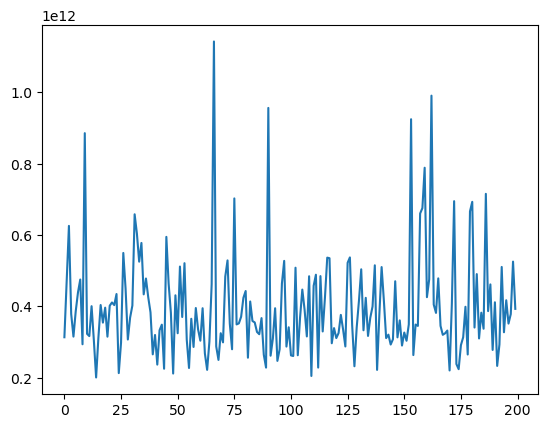

In [77]:
plt.plot(loss_values_2)
plt.show()

In [164]:

# Evaluate the model
with torch.no_grad():
    total_loss = 0
    for features, labels in test_loader:
        features = features.type(torch.float)
        labels = labels.type(torch.float)
        outputs = model(features)
        loss = criterion(outputs, labels.unsqueeze(1))
        total_loss += loss.item()

    print(f'Test MSE: {total_loss / len(test_loader):.4f}')

Test MSE: 306204325784.5657


autre modele, reg linéaire

In [170]:
model = linear_model.LinearRegression().fit(X_train, y_train.values)


In [172]:
def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [173]:
pred = model.predict(X_test)

In [174]:
pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')

:Scatter   [True Values]   (Predicted Values)

In [175]:
pd.DataFrame({'Error Values': (y_test - pred)}).hvplot.kde()

:Distribution   [Error Values]   (Density)

In [178]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(linear_model.LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

Test set evaluation:
_____________________________________
MAE: 70867.24508856749
MSE: 9801501775.187407
RMSE: 99002.53418568338
R2 Square 0.8321144873367763
__________________________________
Train set evaluation:
_____________________________________
MAE: 70710.2883124323
MSE: 10017848488.801676
RMSE: 100089.20265843702
R2 Square 0.8382061737021944
__________________________________


In [179]:
results_df

Model           MAE           MSE          RMSE  R2 Square  \
0  Linear Regression  70867.245089  9.801502e+09  99002.534186   0.832114   

   Cross Validation  
0          0.833681

In [181]:
class HousePriceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(HousePriceModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)  # Dropout after the last hidden layer
        self.linear4 = nn.Linear(hidden_dim3, output_dim)

    def forward(self, x):
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.relu3(self.linear3(x))
        x = self.dropout(x)  # Apply dropout after the last hidden layer
        return self.linear4(x)

# Create the model instance
model = HousePriceModel(torch_X_train.shape[1], 32, 64, 128, 1)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Training loop
for epoch in tqdm(range(100)):
    for features, labels in train_loader:
        features = features.type(torch.float)
        labels = labels.type(torch.float)
        
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(features)
        # Calculate loss
        loss = loss_fn(output, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Optional: Evaluate on test data during training (not shown for brevity)

print(f"Finished training for {epoch + 1} epochs")

  0%|          | 0/100 [00:00<?, ?it/s]/Users/eeekon/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/eeekon/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:20<00:00,  4.81it/s]

Finished training for 100 epochs


In [182]:
pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')

:Scatter   [True Values]   (Predicted Values)

In [183]:
pd.DataFrame(r.history).hvplot.line(y=['loss', 'val_loss'])

NameError: name 'r' is not defined